# Test QAOA with 3 qubit problem on simulator and real device.
We will create the ideal circuit with the help of IBMQ by using QAOA in qiskit terra.
Afterwards, we will calculate the outcome with statevector and unitary sim.
Then we transpile the circuit to be used on real device.
For both we will show the measurement outcome.


In [1]:
import numpy as np 
from numpy import pi

from qiskit import IBMQ, QuantumRegister, ClassicalRegister, QuantumCircuit, execute, transpile, BasicAer
from qiskit_optimization.algorithms import CplexOptimizer
from qiskit_optimization import QuadraticProgram
from qiskit.visualization import plot_histogram, plot_state_qsphere
from qiskit.quantum_info.operators import Operator

from utilities.helpers import create_qaoa_meo

/home/tom/anaconda3/envs/Qiskit_Ocean/lib/python3.8/site-packages/qiskit/optimization/__init__.py:92: DeprecationWarning: The package qiskit.optimization is deprecated. It was moved/refactored to qiskit_optimization (pip install qiskit-optimization). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_package('optimization', 'qiskit_optimization', 'qiskit-optimization')


In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

In [3]:
# select linear program to solve
qp = QuadraticProgram()
qp.read_from_lp_file("example.lp")
# solve classically as reference
cplex = CplexOptimizer()
print(cplex.solve(qp))
qp.to_docplex().prettyprint()

optimal function value: -3.0
optimal value: [1. 1. 1.]
status: SUCCESS
// This file has been generated by DOcplex
// model name is: example_qp
// single vars section
dvar bool x_0;
dvar bool x_2;
dvar bool x_1;

minimize
 - x_0 - x_2 [ - x_0^2 + x_0*x_2 - 2 x_2*x_1 + x_1^2 ];
 
subject to {
 A0_eq_b0:
  - x_2 + x_1 == 0;

}


In [4]:
# solve qp with Minimum Eigen Optimizer QAOA on local simulator
qaoa = create_qaoa_meo()
res = qaoa.solve(qp)
res

optimal function value: -3.0
optimal value: [1. 1. 1.]
status: SUCCESS

In [5]:
def create_qaoa_circuit() -> QuantumCircuit:
    """ taken from IBMQ Experience """
    qreg_q = QuantumRegister(3, 'q')
    circuit = QuantumCircuit(qreg_q)

    circuit.h(qreg_q[0])
    circuit.h(qreg_q[1])
    circuit.cx(qreg_q[1], qreg_q[0])
    circuit.rz(-0.06942544294642758, qreg_q[0])
    circuit.cx(qreg_q[1], qreg_q[0])
    circuit.rz(-0.20827632883928274, qreg_q[0])
    circuit.rx(0.7530122052855767, qreg_q[0])
    circuit.h(qreg_q[2])
    circuit.cx(qreg_q[2], qreg_q[1])
    circuit.rz(1.2496579730356965, qreg_q[1])
    circuit.cx(qreg_q[2], qreg_q[1])
    circuit.rz(-0.20827632883928274, qreg_q[1])
    circuit.rx(0.7530122052855767, qreg_q[1])
    circuit.rx(0.7530122052855767, qreg_q[2])
    
    return circuit

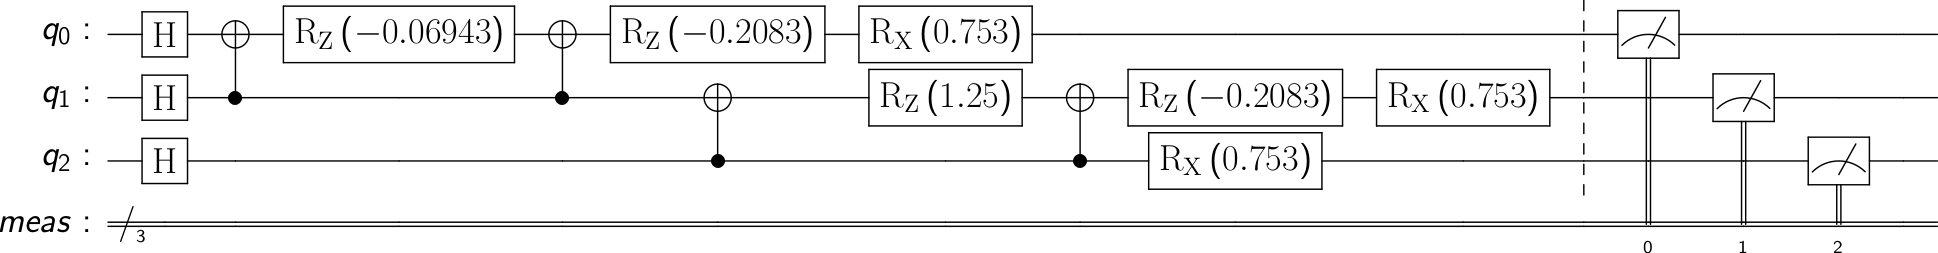

In [6]:
qc = create_qaoa_circuit()
qc_measure = create_qaoa_circuit()
qc_measure.measure_all()
qc_measure.draw(output='latex')

[0.244-0.365j 0.208-0.486j 0.07 -0.096j 0.042-0.106j 0.025-0.019j
 0.046-0.043j 0.185-0.432j 0.147-0.502j]
/home/tom/anaconda3/envs/Qiskit_Ocean/lib/python3.8/site-packages/qiskit/visualization/state_visualization.py:705: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


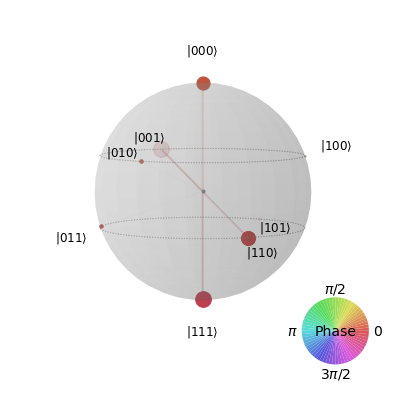

In [7]:
def pretty_print(x):
    with np.printoptions(precision=3, suppress=True):
        print(x)

result_statevec_sim = execute(qc, BasicAer.get_backend('statevector_simulator')).result()
psi = result_statevec_sim.get_statevector(qc, decimals=3)
plot_state_qsphere(psi)

In [8]:
result_unitary_sim = execute(qc, BasicAer.get_backend('unitary_simulator')).result()
U = result_unitary_sim.get_unitary(qc, decimals=3)
op = Operator(qc)
pretty_print(U)

[[ 0.244-0.365j  0.51 -0.124j  0.244-0.219j  0.401-0.006j  0.191-0.25j
   0.36 -0.058j  0.101+0.055j  0.06 +0.12j ]
 [ 0.208-0.486j -0.402+0.188j  0.225-0.326j -0.314+0.071j  0.181-0.323j
  -0.303+0.105j  0.117+0.02j  -0.048-0.084j]
 [ 0.07 -0.096j  0.124-0.041j -0.301-0.096j -0.175-0.319j  0.347+0.056j
   0.237+0.297j -0.424-0.172j -0.213-0.463j]
 [ 0.042-0.106j -0.097+0.03j  -0.363-0.065j  0.199+0.253j  0.374+0.023j
  -0.235-0.254j -0.494-0.141j  0.243+0.392j]
 [ 0.025-0.019j  0.047+0.018j  0.314+0.112j  0.182+0.34j  -0.268-0.153j
  -0.119-0.362j -0.379-0.249j -0.137-0.522j]
 [ 0.046-0.043j -0.047+0.014j  0.377+0.069j -0.198-0.265j -0.366-0.111j
   0.163+0.265j -0.498-0.204j  0.193+0.408j]
 [ 0.185-0.432j  0.478-0.215j -0.148+0.299j -0.337+0.125j -0.201+0.268j
  -0.377+0.072j  0.042-0.012j  0.028+0.029j]
 [ 0.147-0.502j -0.403+0.24j  -0.136+0.335j  0.304-0.143j -0.18 +0.337j
   0.314-0.109j  0.055+0.004j -0.048-0.032j]]


In [13]:
x = np.zeros(2**3)
x[0] = 1
pretty_print(op.data.dot(x))
pretty_print(psi)

[0.244-0.365j 0.208-0.486j 0.07 -0.096j 0.042-0.106j 0.025-0.019j
 0.046-0.043j 0.185-0.432j 0.147-0.502j]
[0.244-0.365j 0.208-0.486j 0.07 -0.096j 0.042-0.106j 0.025-0.019j
 0.046-0.043j 0.185-0.432j 0.147-0.502j]


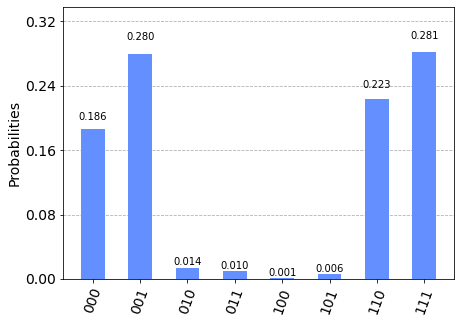

In [10]:
result_meas = execute(qc_measure, BasicAer.get_backend('qasm_simulator'), shots=4096)
counts = result_meas.result().get_counts()
plot_histogram(counts)